In [35]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

RANDOM_SEED = 42

mps


In [36]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 1000, noise = 0.1, random_state=RANDOM_SEED)
X.shape, y.shape

((1000, 2), (1000,))

In [37]:
import pandas as pd
moons = pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})
moons.head(10)

,X1,X2,label
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0
5,0.613706,-0.242369,1
6,0.286495,-0.201277,1
7,-0.056104,0.477079,1
8,1.604217,-0.303541,1
9,0.709641,0.858867,0


In [38]:
moons.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

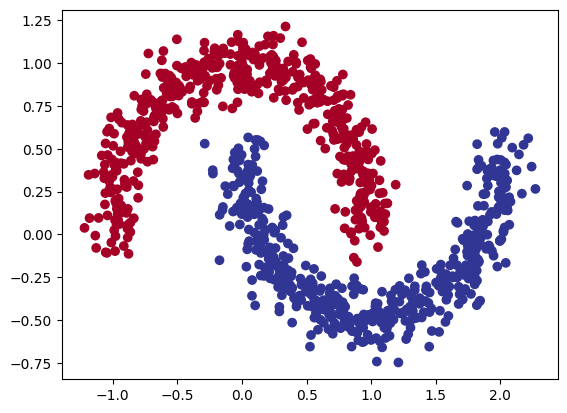

In [39]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [40]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [48]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [49]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.1)

In [50]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [51]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss:.5f} acc {acc:.2f} | Test Loss {test_loss:.5f} acc {test_acc:.2f}")

Epoch 0 | Train Loss 0.69525 acc 37.62 | Test Loss 0.69437 acc 49.50
Epoch 10 | Train Loss 0.68215 acc 75.62 | Test Loss 0.68216 acc 72.00
Epoch 20 | Train Loss 0.66808 acc 79.38 | Test Loss 0.66942 acc 76.50
Epoch 30 | Train Loss 0.65117 acc 77.88 | Test Loss 0.65357 acc 73.50
Epoch 40 | Train Loss 0.62704 acc 75.88 | Test Loss 0.63103 acc 68.50
Epoch 50 | Train Loss 0.59457 acc 75.38 | Test Loss 0.60068 acc 69.50
Epoch 60 | Train Loss 0.55481 acc 75.88 | Test Loss 0.56329 acc 72.00
Epoch 70 | Train Loss 0.51006 acc 76.88 | Test Loss 0.52069 acc 73.50
Epoch 80 | Train Loss 0.46489 acc 78.25 | Test Loss 0.47746 acc 75.50
Epoch 90 | Train Loss 0.42470 acc 79.50 | Test Loss 0.43846 acc 76.50
Epoch 100 | Train Loss 0.39179 acc 81.12 | Test Loss 0.40561 acc 77.00
Epoch 110 | Train Loss 0.36553 acc 82.88 | Test Loss 0.37834 acc 79.50
Epoch 120 | Train Loss 0.34417 acc 84.00 | Test Loss 0.35538 acc 81.00
Epoch 130 | Train Loss 0.32626 acc 84.62 | Test Loss 0.33558 acc 82.50
Epoch 140 | Train

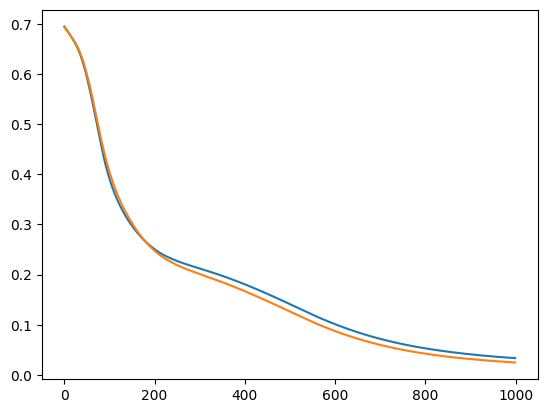

In [52]:
plt.plot(epoch_count, train_loss_values)
plt.plot(epoch_count, test_loss_values)

In [45]:
y_train.shape

torch.Size([800])

In [53]:

# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

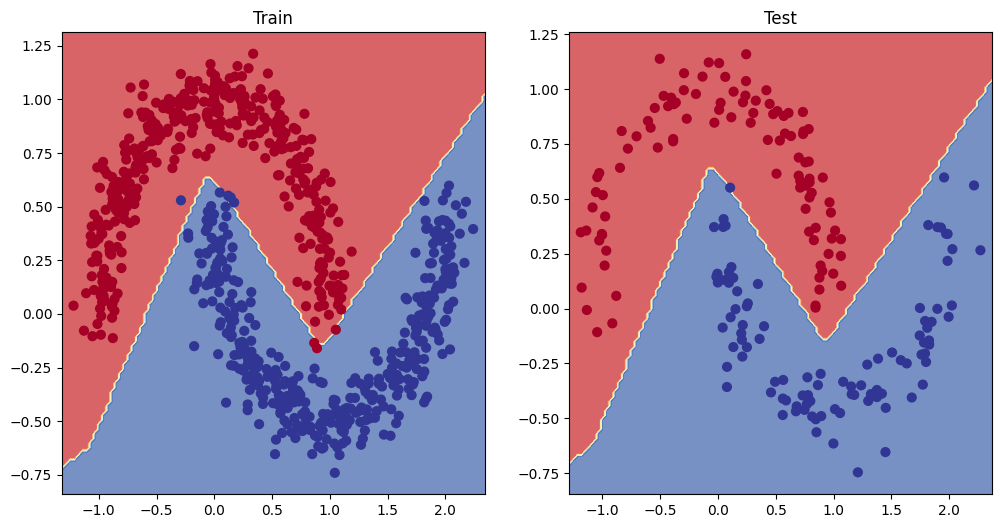

In [55]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 7. Multi-class classification

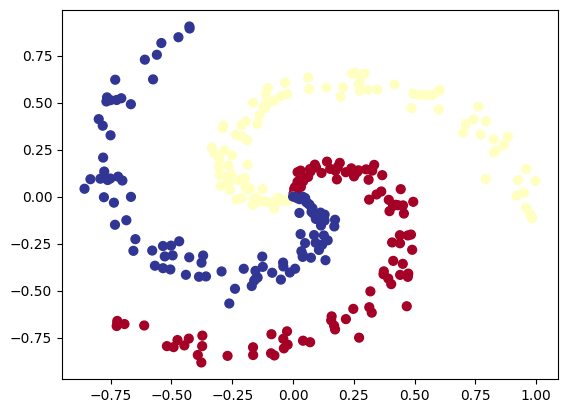

In [218]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [219]:
X.shape, y.shape

((300, 2), (300,))

In [220]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=RANDOM_SEED)


In [221]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([240]),
 torch.Size([60, 2]),
 torch.Size([60]))

In [222]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

In [223]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [224]:
class SpiralModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units = 10):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_1 = SpiralModelV0(in_features=2, out_features=3, hidden_units=10).to(device)
model_1

SpiralModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [225]:
model_1.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.5170,  0.4374],
                      [ 0.3693, -0.0011],
                      [ 0.6850, -0.2808],
                      [-0.1646, -0.3574],
                      [ 0.1018,  0.1872],
                      [ 0.0563, -0.3978],
                      [-0.3183,  0.2405],
                      [-0.6200, -0.1101],
                      [-0.0157, -0.2865],
                      [ 0.2573,  0.0456]], device='mps:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.4964, -0.0628, -0.4463,  0.4996,  0.0987, -0.2025, -0.4661,  0.1657,
                      -0.6744,  0.1862], device='mps:0')),
             ('linear_layer_stack.2.weight',
              tensor([[ 1.5636e-01, -2.7740e-01, -2.0703e-01, -2.2734e-01,  2.6579e-01,
                        2.6883e-01,  1.9796e-02,  2.9688e-01, -1.0572e-01, -3.0700e-01],
                      [ 1.1046e-01,  1.1203e-01,  3.1002e-01, -9.1529e-05,  2.4236e-01,
          

In [226]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [227]:
y_untrained_logits = model_1(X_train)
y_pred_probs = torch.softmax(y_untrained_logits, dim=1)
y_pred = torch.argmax(y_pred_probs, dim=1)

In [228]:
y_untrained_logits.shape, y_pred_probs.shape, y_pred.shape

(torch.Size([240, 3]), torch.Size([240, 3]), torch.Size([240]))

In [229]:
y_untrained_logits[:10],y_pred_probs[:10],y_pred[:10], y_train[:10]

(tensor([[ 0.0101, -0.2722,  0.1061],
         [ 0.0234, -0.2915,  0.1229],
         [ 0.0054, -0.2739,  0.0860],
         [ 0.0437, -0.2836,  0.1112],
         [ 0.0286, -0.2882,  0.0785],
         [ 0.0231, -0.2769,  0.0850],
         [ 0.0162, -0.2776,  0.0836],
         [-0.0274, -0.2521,  0.0975],
         [ 0.0267, -0.2840,  0.1182],
         [ 0.0441, -0.2840,  0.1112]], device='mps:0', grad_fn=<SliceBackward0>),
 tensor([[0.3503, 0.2641, 0.3856],
         [0.3528, 0.2575, 0.3897],
         [0.3521, 0.2663, 0.3816],
         [0.3583, 0.2583, 0.3834],
         [0.3598, 0.2621, 0.3782],
         [0.3565, 0.2641, 0.3793],
         [0.3552, 0.2648, 0.3800],
         [0.3411, 0.2725, 0.3865],
         [0.3535, 0.2591, 0.3874],
         [0.3585, 0.2582, 0.3833]], device='mps:0', grad_fn=<SliceBackward0>),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='mps:0'),
 tensor([2, 0, 0, 1, 1, 0, 0, 2, 0, 1], device='mps:0'))

In [230]:
y_pred.detach().cpu().numpy()

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [231]:
import numpy as np
np.unique(y_pred.detach().cpu().numpy(), return_counts=True)

(array([2]), array([240]))

In [232]:
acc = acc_fn(y_pred, y_train.int())
acc

tensor(0.3250, device='mps:0')

In [233]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.02)

In [234]:
torch.manual_seed = 42

epochs = 1000

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().cpu().numpy())
    test_loss_values.append(test_loss.detach().cpu().numpy())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss:.5f} acc {acc:.2f} | Test Loss {test_loss:.5f} acc {test_acc:.2f}")

Epoch 0 | Train Loss 1.11561 acc 0.32 | Test Loss 1.08517 acc 0.37
Epoch 10 | Train Loss 0.94633 acc 0.52 | Test Loss 0.92631 acc 0.53
Epoch 20 | Train Loss 0.72413 acc 0.56 | Test Loss 0.73663 acc 0.55
Epoch 30 | Train Loss 0.66178 acc 0.59 | Test Loss 0.63864 acc 0.60
Epoch 40 | Train Loss 0.59384 acc 0.65 | Test Loss 0.54431 acc 0.72
Epoch 50 | Train Loss 0.51330 acc 0.73 | Test Loss 0.46689 acc 0.77
Epoch 60 | Train Loss 0.43107 acc 0.79 | Test Loss 0.38612 acc 0.82
Epoch 70 | Train Loss 0.35427 acc 0.90 | Test Loss 0.30911 acc 0.92
Epoch 80 | Train Loss 0.27247 acc 0.95 | Test Loss 0.24772 acc 0.95
Epoch 90 | Train Loss 0.21122 acc 0.96 | Test Loss 0.19681 acc 0.95
Epoch 100 | Train Loss 0.17117 acc 0.96 | Test Loss 0.15081 acc 0.97
Epoch 110 | Train Loss 0.14512 acc 0.96 | Test Loss 0.12290 acc 0.97
Epoch 120 | Train Loss 0.12755 acc 0.96 | Test Loss 0.10171 acc 0.97
Epoch 130 | Train Loss 0.11317 acc 0.97 | Test Loss 0.08332 acc 0.98
Epoch 140 | Train Loss 0.10228 acc 0.96 | Tes

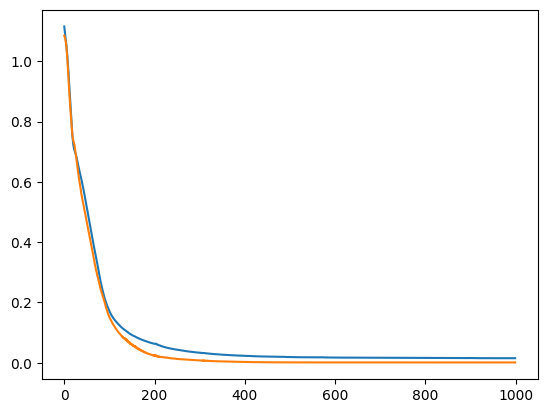

In [235]:
plt.plot(epoch_count, train_loss_values)
plt.plot(epoch_count, test_loss_values)

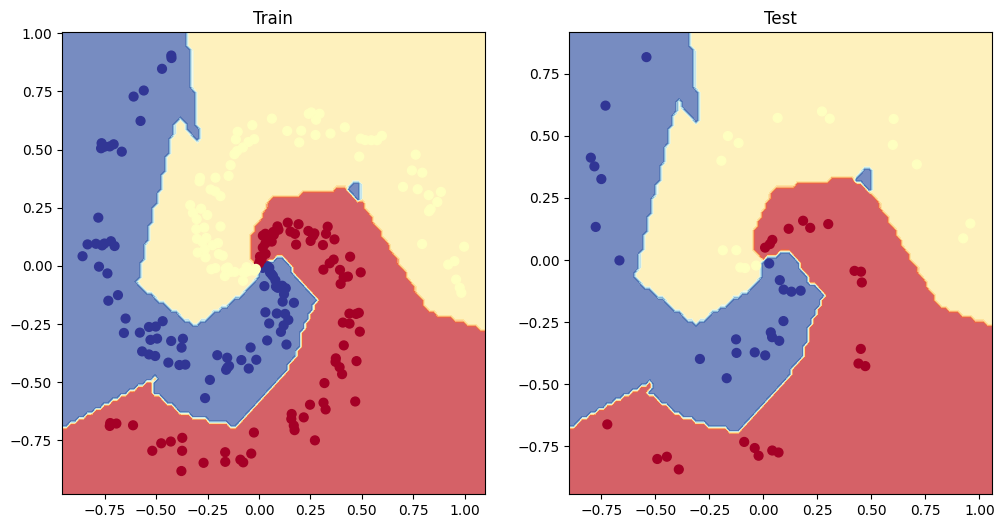

In [236]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)